# Strain mapping with all calibrations
___

## 3A: Measure Bragg Scattering - Find Bragg disks

Find the Bragg disks in the experimental 4DSTEM scan.  The Bragg disks are located using cross-correlative template matching against the vacuum probe template.  Once the Bragg disks are identified, the Bragg vector map is also generated.

___

- Inputs:
  - vacuum probe template
  - calibration sample scan
- Outputs:
  - Bragg peaks, uncorrected, for the calibration sample
  - Bragg vector map, uncorrected, for the calibration sample

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from time import time

from py4DSTEM.process.braggdiskdetection import find_Bragg_disks_selected, find_Bragg_disks
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map, threshold_Braggpeaks
from py4DSTEM.file.datastructure import PointList, PointListArray
from py4DSTEM.file.io import FileBrowser, read, append

In [3]:
# Examine contents of sampledata.h5

fp = "/media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/LFP100_P1/sampledata.h5"
browser = py4DSTEM.file.io.FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    calibration_4DSTEM_scan             DataCube            
   1    experimental_4DSTEM_scan            DataCube            
   2    vacuum_4DSTEM_scan                  DataCube            
   3    CBED_shadow_image                   RealSlice           
   4    HAADF_image                         RealSlice           


In [4]:
# Load the experimental scan

dc = browser.get_dataobject('experimental_4DSTEM_scan')
browser.close()

In [11]:
# Examine contents of processing_sampledata.h5

fp_processing = "/media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/LFP100_P1/processing_sampledata.h5"
browser_processing = py4DSTEM.file.io.FileBrowser(fp_processing)
browser_processing.show_dataobjects()

 Index                  Name                        Type        
   0    braggvectormap_calibrationdata_shiftcorrectedDiffractionSlice    
   1    braggvectormap_corrected_calibrationdataDiffractionSlice    
   2    braggvectormap_uncorrected_calibrationdataDiffractionSlice    
   3    probe                               DiffractionSlice    
   4    diffractionshifts_calibrationdata   RealSlice           
   5    virtual_image                       RealSlice           
   6    Qpixel_calibration                  PointList           
   7    RQ_rotational_offset_degrees        PointList           
   8    elliptical_distortion               PointList           
   9    braggpeaks_corrected_calibrationdataPointListArray      
   10   braggpeaks_uncorrected_calibrationdataPointListArray      


In [12]:
# Load the vacuum probe

probe = browser_processing.get_dataobject('probe')
im = browser_processing.get_dataobject('virtual_image').data
browser_processing.close()

probe_kernel = probe.slices['probe_kernel']

### Test parameters on a few diffraction patterns

Analyzed 3 diffraction patterns in 0h 0m 0s


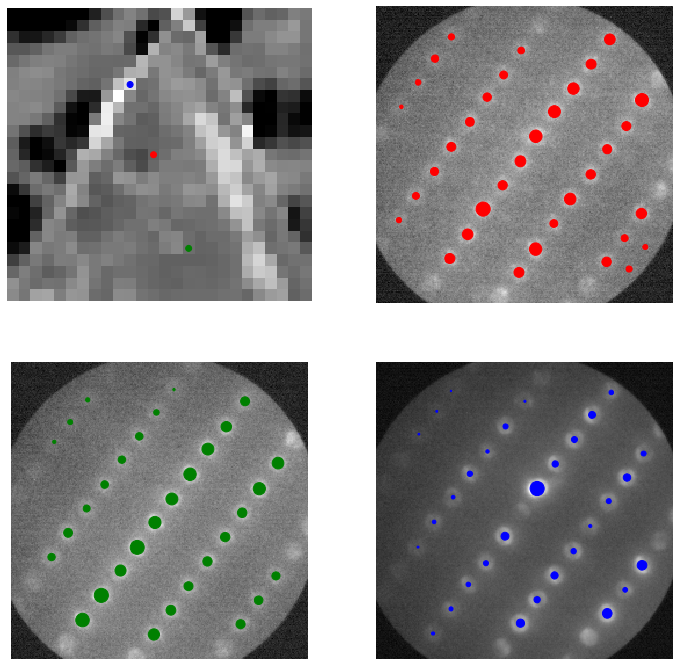

In [13]:
######## Parameters ########

# Select scan positions
Rxs = 12,20,6
Rys = 12,15,10

# Peak detection parameters
corrPower = 1
sigma = 2
edgeBoundary = 20
maxNumPeaks = 70
minPeakSpacing = 10
minRelativeIntensity = 0.001
subpixel = 'multicorr'
upsample_factor = 16

# Display parameters
power=0.3
size_scale_factor = 200       # Set to zero to make all points the same size

############################

# Find peaks
peaks = find_Bragg_disks_selected(dc, probe_kernel, Rxs, Rys,
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks,
                                  subpixel=subpixel,
                                  upsample_factor=upsample_factor)

# Show
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(im)
ax11.scatter(Rys,Rxs,color=('r','g','b'))
ax12.matshow(dc.data[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data[Rxs[2],Rys[2],:,:]**power)

if size_scale_factor == 0:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r')
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g')
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b')
else:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r',s=size_scale_factor*peaks[0].data['intensity']/np.max(peaks[0].data['intensity']))
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g',s=size_scale_factor*peaks[1].data['intensity']/np.max(peaks[1].data['intensity']))
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b',s=size_scale_factor*peaks[2].data['intensity']/np.max(peaks[2].data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Find Bragg disks in all diffraction patterns

In [14]:
verbose = True

braggpeaks = find_Bragg_disks(dc, probe_kernel,
                              corrPower=corrPower,
                              sigma=sigma,
                              edgeBoundary=edgeBoundary,
                              minRelativeIntensity=minRelativeIntensity,
                              minPeakSpacing=minPeakSpacing,
                              maxNumPeaks=maxNumPeaks,
                              subpixel=subpixel,
                              upsample_factor=upsample_factor,
                              verbose=verbose)
braggpeaks.name = 'braggpeaks'

Analyzing: |**************************************************| 100.0% Complete

Analyzed 650 diffraction patterns in 0h 0m 20s


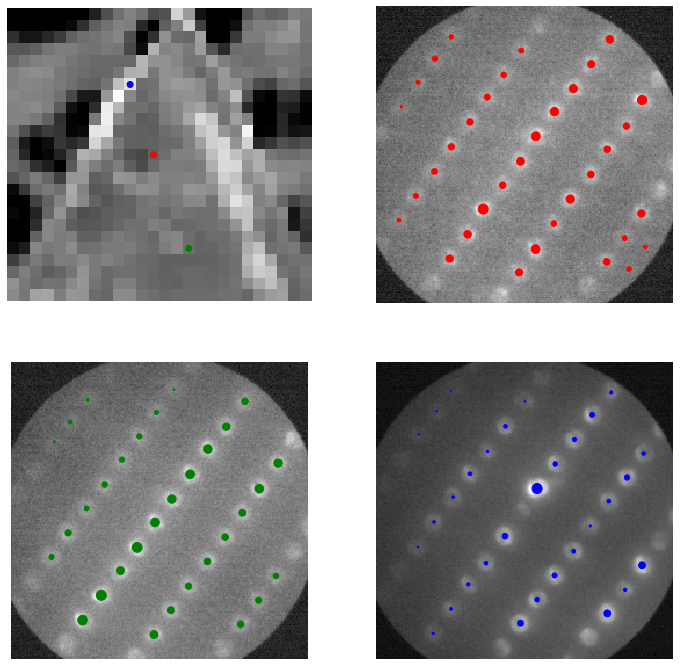

In [15]:
# Show results for a few DPs

Rxs = 12,20,6
Rys = 12,15,10
power = 0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(im)
ax11.scatter(Rys,Rxs,color=('r','g','b'))

ax12.matshow(dc.data[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data[Rxs[2],Rys[2],:,:]**power)

peaks0 = braggpeaks.get_pointlist(Rxs[0],Rys[0])
peaks1 = braggpeaks.get_pointlist(Rxs[1],Rys[1])
peaks2 = braggpeaks.get_pointlist(Rxs[2],Rys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Get Bragg vector map

In [16]:
# Get Bragg vector map

braggvectormap = get_bragg_vector_map(braggpeaks,dc.Q_Nx,dc.Q_Ny)

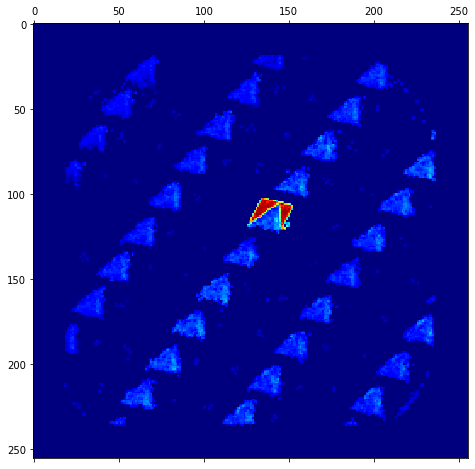

In [17]:
# Show

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**0.25,cmap='jet')
plt.show()

### Save

In [18]:
braggvectormap_diffslice = py4DSTEM.file.datastructure.DiffractionSlice(braggvectormap, name='braggvectormap_uncorrected_experiment')
braggpeaks.name = 'braggpeaks_uncorrected_experiment'

In [19]:
# Append to processing file

append([braggpeaks,braggvectormap_diffslice], fp_processing)

Opening file /media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/LFP100_P1/processing_sampledata.h5...
Done.
